In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# ! pip install tqdm
from tqdm import tqdm
import joblib
import os


# ! pip install rdkit??
import rdkit
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem.Descriptors import CalcMolDescriptors
from rdkit.ML.Descriptors.MoleculeDescriptors import MolecularDescriptorCalculator as MDC

# Download data

In [2]:
target = 'aa2ar'
url = f'https://dude.docking.org//targets/{target}'
data = './data'
tables = './tables'
path_model = './models'
pics = './pics'

In [3]:
def dir_builder():
    if not os.path.exists(path_model):
        os.mkdir(path_model)
    if not os.path.exists(pics):
        os.mkdir(pics)
    if not os.path.exists(tables):
        os.mkdir(tables)
    if not os.path.exists(data):
        os.mkdir(data)

dir_builder()

In [4]:
active = pd.read_csv(f'{url}/actives_combined.ism', header=None, sep=' ', on_bad_lines='skip')
inactive = pd.read_csv(f'{url}/inactives_combined.ism', header=None, sep=' ', on_bad_lines='skip')
decoys = pd.read_csv(f'{url}/decoys_final.ism', header=None, sep=' ', on_bad_lines='skip')

In [5]:
active = pd.DataFrame({'smiles':active[0], 'label': [1]*len(active[0])})
active_size = active.shape[0]

inactive = pd.DataFrame({'smiles': inactive[0], 'label': [0]*len(inactive[0])})
inactive_size = inactive.shape[0]

decoys = pd.DataFrame({'smiles':decoys[0], 'label': [0]*len(decoys[0])})
decoys_size = decoys.shape[0]

# Feature generation

In [6]:
def RDkit_descriptors(data):
    mols = [Chem.MolFromSmiles(i) for i in data.smiles]
    desc_names = list(CalcMolDescriptors(mols[0]).keys())
    desc_names.append("label")
    mol_descs = []
    for i in tqdm(range(len(data))):
        descriptors = CalcMolDescriptors(mols[i])
        descriptors['label'] = data.label[i]
        mol_descs.append(descriptors)
    return mol_descs, desc_names

In [7]:
mol_classes = [active, inactive, decoys]
classes_names = ['active', 'inactive', 'decoys']

In [8]:
for mol_class, class_name in zip(mol_classes, classes_names):
    mol_descs, desc_names = RDkit_descriptors(mol_class)
    descriptors_df = pd.DataFrame(mol_descs, columns=desc_names)
    descriptors_df.to_csv(f'{data}/{class_name}_descs_raw.csv', index=False)
    print(class_name)

100%|██████████| 3050/3050 [00:32<00:00, 94.47it/s] 


active


100%|██████████| 192/192 [00:01<00:00, 113.55it/s]


inactive


100%|██████████| 31550/31550 [05:57<00:00, 88.24it/s] 


decoys


# Data preparation

In [12]:
active = pd.read_csv('./data/active_descs_raw.csv', index_col=None)
active_size = active.shape[0]

inactive = pd.read_csv('./data/inactive_descs_raw.csv', index_col=None)
inactive_size = inactive.shape[0]

decoys = pd.read_csv('./data/decoys_descs_raw.csv', index_col=None)
decoys_size = decoys.shape[0]

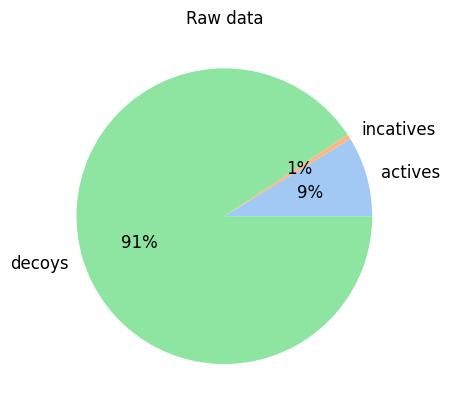

In [13]:
colors = sns.color_palette('pastel')[0:5]
data = [active_size, inactive_size, decoys_size]
labels = ['actives', 'incatives', 'decoys']
plt.pie(data, labels=labels, colors = colors, autopct='%.0f%%', textprops={"fontsize":12})
plt.title('Raw data')
# plt.show()
plt.savefig(f'{pics}/raw_data.png')

# Data resampling

In [20]:
decoys_new_size = active_size - inactive_size
split_decoys = decoys.sample(n=decoys_new_size)

balanced_data = pd.concat([active, inactive, split_decoys], ignore_index=True)
balanced_data.to_csv(f'data/balanced_dataframe.csv',index=False)

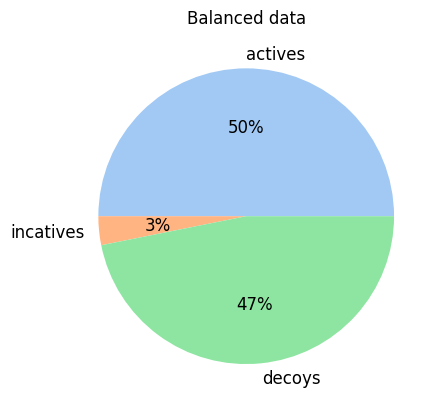

In [18]:
colors = sns.color_palette('pastel')[0:5]
data = [active_size, inactive_size, decoys_new_size]
labels = ['actives', 'incatives', 'decoys']
plt.pie(data, labels=labels, colors = colors, autopct='%.0f%%', textprops={"fontsize":12})
plt.title('Balanced data')
# plt.show()
plt.savefig(f'{pics}/balanced_data.png')